In [69]:
# Run command to install required packages
!pip install -r requirements.txt

In [57]:
# Imports all the needed dependencies for the project.
import os 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import json



In [58]:
# Load the dataset
rawDataPath = "synthetic_defects_5k.csv"
assert os.path.exists(rawDataPath), f"{rawDataPath} not found."

rawDF = pd.read_csv(rawDataPath)
rawDF = (
    rawDF
    .drop_duplicates()
    .dropna()
    .reset_index(drop=True)
)

In [59]:
# Combine text columns into a single column for analysis
rawDF["combined"] = (
    rawDF["Description"] + " " +
    rawDF["Root Cause"] + " " +
    rawDF["Path to Fix"]
)


In [60]:
# Create a TF-IDF vectorizer to convert text data into numerical format
vectorizer = TfidfVectorizer(
    max_features=1000,           # cap vocab size
    stop_words="english",        # drop common fillers
)
X_tfidf = vectorizer.fit_transform(rawDF["combined"])


In [61]:
# Print the shape of the TF-IDF matrix
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Variance diagnostics (optional print)
expl_var = pca.explained_variance_ratio_
print(f"Explained variance ratio: {expl_var[0]:.3f}, {expl_var[1]:.3f}")

Explained variance ratio: 0.064, 0.061


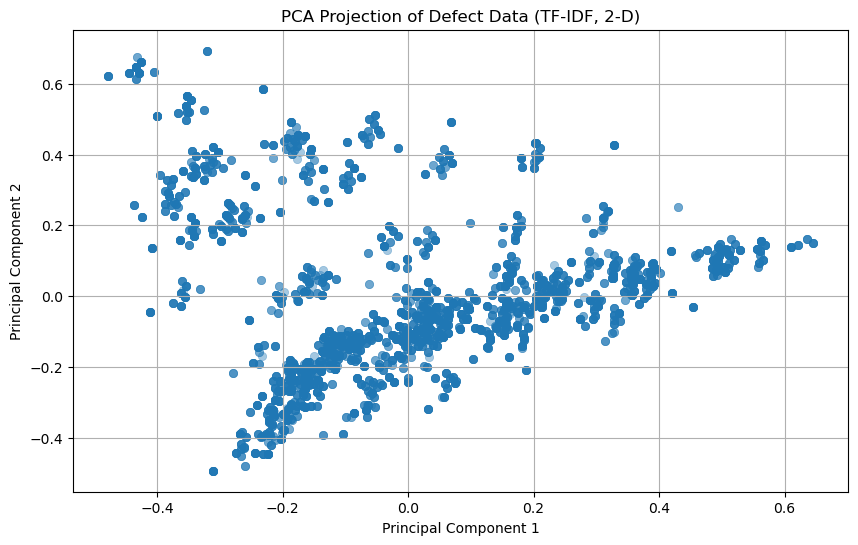

Plot saved to: pca_defects_projection.png


In [62]:
# Plot the PCA projection
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    alpha=0.4,
    edgecolor=None
)
plt.title("PCA Projection of Defect Data (TF-IDF, 2-D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)

plot_path = "pca_defects_projection.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Plot saved to: {plot_path}")

In [63]:
# Save the PCA results back to the original DataFrame
rawDF["PC1"] = X_pca[:, 0]
rawDF["PC2"] = X_pca[:, 1]
rawDF.to_csv("defects_with_pca.csv", index=False)

# (b) Numpy matrix if needed elsewhere
import numpy as np
np.save("X_pca.npy", X_pca)

print("Finished: cleaned data, PCA matrix, and plot saved.")

Finished: cleaned data, PCA matrix, and plot saved.


In [64]:
# Load the PCA results for further analysis
df = pd.read_csv("defects_with_pca.csv")

#  Create a list of dictionaries with instruction/output format
converted = []

for _, row in df.iterrows():
    instruction = (
        "Given a defect report and its root cause, suggest a fix path.\n\n"
        f"Defect: {row['Description']}\n"
        f"Root cause: {row['Root Cause']}"
    )
    output = row["Path to Fix"]
    converted.append({"instruction": instruction, "response": output})
    
# Save the converted data to a JSON file
with open("defects_instructions.json", "w") as f:
    json.dump(converted, f, indent=2)
print("Converted data saved to defects_instructions.json")

Converted data saved to defects_instructions.json


In [68]:
# Script to convert a base model to 4-bit quantization using bitsandbytes
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from dotenv import load_dotenv
import os
import accelerate

load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")

script_dir = os.getcwd()
base_model_path = os.path.join(script_dir, "models", "base")
fourbit_model_path = os.path.join(script_dir, "models", "4bit")
os.makedirs(fourbit_model_path, exist_ok=True)
os.makedirs(base_model_path, exist_ok=True)


modelName = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(modelName, use_fast=True)
baseModel = AutoModelForCausalLM.from_pretrained(modelName, cache_dir=base_model_path, trust_remote_code=True)
baseModel.save_pretrained(base_model_path)
tokenizer.save_pretrained(base_model_path)

bnb_config_4bit = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = torch.bfloat16,
)

model_4bit = AutoModelForCausalLM.from_pretrained(
    modelName,
    quantization_config=bnb_config_4bit,
    cache_dir=fourbit_model_path,
    trust_remote_code=True,
    device_map = "auto"
)
model_4bit.save_pretrained(fourbit_model_path)










Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ValueError: Using a `device_map`, `tp_plan`, `torch.device` context manager or setting `torch.set_default_device(device)` requires `accelerate`. You can install it with `pip install accelerate`